# Train bidirectional-`LSTM`

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet

#### Imports

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # for gradient optimization
import serket as sk
import functools as ft
import time

EPOCHS = 100
LR = 1e-3

#### Data preparation

In [3]:
# 101 samples of 1D data
x = jnp.linspace(0, 1, 101).reshape(-1, 1)
y = jnp.sin(2 * jnp.pi * x)
y += 0.1 * jr.normal(jr.PRNGKey(0), y.shape)

# we will use 2 time steps to predict the next time step
x_train = jnp.stack([x[:-1], x[1:]], axis=1)

# 100 minibatches x 1 sample x 2 time steps x 1D data
x_train = jnp.reshape(x_train, (100, 1, 2, 1))

# 100 minibatches x 1 samples x 1D data
y_train = jnp.reshape(y[1:], (100, 1, 1))

#### Model creation

In [4]:
k1, k2, k3 = jr.split(jr.PRNGKey(0), 3)


class BiLstm(sk.TreeClass):
    def __init__(
        self,
        in_features: int,
        hidden_dim: int,
        out_features: int,
        key: jax.random.KeyArray,
    ):
        k1, k2, k3 = jr.split(key, 3)
        self.cell1 = sk.nn.LSTMCell(in_features, hidden_dim, key=k1)  # forward cell
        self.cell2 = sk.nn.LSTMCell(in_features, hidden_dim, key=k2)  # backward cell
        self.cell3 = sk.nn.LSTMCell(hidden_dim * 2, out_features, key=k3)  # final cell

    def __call__(self, x):
        # here we have forward and backward cells passed to `ScanRNN`
        x = sk.nn.ScanRNN(self.cell1, self.cell2, return_sequences=True)(x)
        # here we have only forward cell
        # here the in_features is 64*2 (64 for each cell from previous layer)
        # we set return_sequences=False to return only the last output of the sequence
        x = sk.nn.ScanRNN(self.cell3)(x)
        return x


nn = BiLstm(1, 64, 1, key=jax.random.PRNGKey(0))

# 1) mask the non-jaxtype parameters
nn = sk.tree_mask(nn)

# 2) initialize the optimizer state
optim = optax.adam(LR)
optim_state = optim.init(nn)

#### Training functions

In [5]:
def mse(x, y):
    assert x.shape == y.shape
    return jnp.mean((x - y) ** 2)


@ft.partial(jax.grad, has_aux=True)
def loss_func(nn, x, y):
    # pass non-jaxtype over jax transformation
    # using `tree_mask`/`tree_unmask` scheme
    # 3) unmask the non-jaxtype parameters to be used in the computation
    nn = sk.tree_unmask(nn)

    # 4) vectorize the computation over the batch dimension
    # and get the logits
    # here we dont vectorize over state argument so we use `None`
    logits = jax.vmap(nn)(x)

    # 5) use the appropriate loss function
    loss = mse(logits, y)
    return loss, (loss, logits)


@jax.jit
def train_step(nn, optim_state, x, y):
    grads, (loss, logits) = loss_func(nn, x, y)
    updates, optim_state = optim.update(grads, optim_state)
    nn = optax.apply_updates(nn, updates)
    return nn, optim_state, (loss, logits)

#### Train and plot results

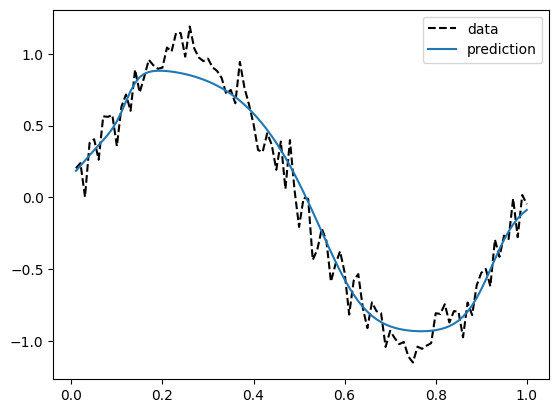

In [6]:
for i in range(1, EPOCHS + 1):
    t0 = time.time()
    for j, (xb, yb) in enumerate(zip(x_train, y_train)):
        nn, optim_state, (loss, logits) = train_step(nn, optim_state, xb, yb)
        print(
            f"Epoch: {i:003d}/{EPOCHS:003d}\t"
            f"Batch: {j+1:003d}/{len(x_train):003d}\t"
            f"Batch loss: {loss:3e}\t"
            f"Time: {time.time() - t0:.3f}",
            end="\r",
        )


# 6) un-mask the trained network
eval_nn = sk.tree_unmask(nn)


y_pred = jax.vmap(eval_nn)(x_train.reshape(-1, 2, 1))
plt.plot(x[1:], y[1:], "--k", label="data")
plt.plot(x[1:], y_pred, label="prediction")
plt.legend()